In [1]:
import pandas as pd, numpy as np
df = pd.read_csv('data/Final_Project_Baseline_Values.csv', 
                 index_col = False, 
                 header = None, 
                 names= ['Metric_Definition', 'Baseline_Val'] )
df

,Metric_Definition,Baseline_Val
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,"Probability of enrolling, given click:",0.206250
5,"Probability of payment, given enroll:",0.530000
6,"Probability of payment, given click",0.109313


In [2]:
# Labelling the metrics for ease of reference
df['Metric'] = ['Cookies', 'Clicks', 'Enrollments (Clicks * Gross_Conversion)',
                'CTP (Clicks/Cookies)', 
                'Gross_Conversion (Enrollments/Clicks)', 
                'Retention (Paid/Enrollments)','Net_Conversion(Paid/Clicks)']
df

,Metric_Definition,Baseline_Val,Metric
0,Unique cookies to view course overview page pe...,40000.000000,Cookies
1,"Unique cookies to click ""Start free trial"" per...",3200.000000,Clicks
2,Enrollments per day:,660.000000,Enrollments (Clicks * Gross_Conversion)
3,"Click-through-probability on ""Start free trial"":",0.080000,CTP (Clicks/Cookies)
4,"Probability of enrolling, given click:",0.206250,Gross_Conversion (Enrollments/Clicks)
5,"Probability of payment, given enroll:",0.530000,Retention (Paid/Enrollments)
6,"Probability of payment, given click",0.109313,Net_Conversion(Paid/Clicks)


In [3]:
# Add Practical Significance level column
df['dmin'] = [3000,240,50,0.01,0.01,0.01,0.0075]
df

,Metric_Definition,Baseline_Val,Metric,dmin
0,Unique cookies to view course overview page pe...,40000.000000,Cookies,3000.0000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000,Clicks,240.0000
2,Enrollments per day:,660.000000,Enrollments (Clicks * Gross_Conversion),50.0000
3,"Click-through-probability on ""Start free trial"":",0.080000,CTP (Clicks/Cookies),0.0100
4,"Probability of enrolling, given click:",0.206250,Gross_Conversion (Enrollments/Clicks),0.0100
5,"Probability of payment, given enroll:",0.530000,Retention (Paid/Enrollments),0.0100
6,"Probability of payment, given click",0.109313,Net_Conversion(Paid/Clicks),0.0075


### Scaling collected data:
For all the calculations to follow we need to scale our collected counts estimates of metrics with the sample size we specified for variance estimation. In this case, from 40000 unique cookies to visit the course overview page per day, to 5000.

#### Measuring Standard Deviation
$$ SD= \sqrt \frac{\ \hat{p}*(1−\hat{p})}{\ n}  $$

In order to estimate variance analytically, we can assume metrics which are probabilities ( $\hat{p}$ ) are binomially distributed, so we can use this formula for the standard deviation: 

This assumption is only valid when the unit of diversion of the experiment is equal to the unit of analysis (the denominator of the metric formula). In the cases when this is not valid, the actual variance might be different and it is recommended to estimate it empirically.

For each metric, we need to plug two variables into the formula: 
<br> $ \hat{p} $ = baseline probability of the event to occur
<br> n  =  sample size

In [4]:
#Predetermined from baseline values
ctp  = 0.08 
gross_conv = 0.206250
retention = 0.53
net_conv = 0.109313

#scale data based on sample size 5000:
sum_cookies = 5000
sum_clicks = ctp * sum_cookies # n size for Gross Conversion & Net Conversion
sum_enrolled = sum_clicks * gross_conv # n size for Retention

# Calculate SD for evaluation metrics:
sd_gross_conv = round(np.sqrt((gross_conv * (1-gross_conv))/sum_clicks),4)
sd_retention = round(np.sqrt((retention * (1-retention))/sum_enrolled),5)
sd_net_conv = round(np.sqrt((net_conv * (1-net_conv))/sum_clicks),4)

df["SD"] = ['NA','NA', 'NA', 'NA', sd_gross_conv, sd_retention, sd_net_conv]
df

,Metric_Definition,Baseline_Val,Metric,dmin,SD
0,Unique cookies to view course overview page pe...,40000.000000,Cookies,3000.0000,NA
1,"Unique cookies to click ""Start free trial"" per...",3200.000000,Clicks,240.0000,NA
2,Enrollments per day:,660.000000,Enrollments (Clicks * Gross_Conversion),50.0000,NA
3,"Click-through-probability on ""Start free trial"":",0.080000,CTP (Clicks/Cookies),0.0100,NA
4,"Probability of enrolling, given click:",0.206250,Gross_Conversion (Enrollments/Clicks),0.0100,0.0202
5,"Probability of payment, given enroll:",0.530000,Retention (Paid/Enrollments),0.0100,0.05495
6,"Probability of payment, given click",0.109313,Net_Conversion(Paid/Clicks),0.0075,0.0156


### Sizing
To calculate the sample size required for the experiment, the largest sample size required for one of the evaluation metrics will effectively be the size to go with. I plug in the following values into the [online calculator](http://www.evanmiller.org/ab-testing/sample-size.html) for sample size:
- Baseline conversion rate: probability of each metric
- Minimum detectable effect: dmin of each metric
- beta: 0.2
- alpha: 0.05

In [5]:
df_eval = df.iloc[4: , 1:]
df_eval.set_index(['Metric'], inplace = True)
df_eval.rename(columns = {'Baseline_Val': 'p'} , inplace = True)

In [6]:
# Sample size using the online calculator
df_eval ['sample_size'] = [25835, 39155, 27413]
df_eval

,p,dmin,SD,sample_size
Metric,,,,
Gross_Conversion (Enrollments/Clicks),0.206250,0.0100,0.0202,25835
Retention (Paid/Enrollments),0.530000,0.0100,0.05495,39155
Net_Conversion(Paid/Clicks),0.109313,0.0075,0.0156,27413


#### Total pageviews required = Total unique cookies accessing course overview page 

- Gross Conversion
<br> Total cookies required in order to have **25835 clicks** per group (control and experiment):
<br> $$ \frac {Clicks * 2}{\ ctp} $$


- Retention
<br> Total cookies required in order to have **39155 enrollments** per group (control and experiment):
<br> $$ \frac{Enrollments * 2}{\ GrossConversion * ctp} $$

- Net Conversion
<br> Total cookies required in order to have **27413 clicks** per group (control and experiment):
<br> $$ \frac{Clicks * 2}{\ ctp} $$

In [7]:
pageviews_gc = round(25835 * 2 / 0.08) 
pageviews_ret = round(39155 * 2 / (0.206250 * 0.08))
pageviews_nc = round(27413 * 2 / 0.08)
df_eval ['page_views'] = [pageviews_gc,pageviews_ret,pageviews_nc]
df_eval

,p,dmin,SD,sample_size,page_views
Metric,,,,,
Gross_Conversion (Enrollments/Clicks),0.206250,0.0100,0.0202,25835,645875
Retention (Paid/Enrollments),0.530000,0.0100,0.05495,39155,4746061
Net_Conversion(Paid/Clicks),0.109313,0.0075,0.0156,27413,685325


### Duration vs Exposure
4 million page views is significantly beyond the estimated 40K views we get on average daily. That would take us at least 100 days to collect the data, and typically any experiments taking longer than a few weeks is not reasonable, hence I decided to <font color=red>drop Retention</font> as a metric. **Net Conversion** has the largest number of page views of the remaining 2 evaluation metrics.

Now, let's calculate the duration at different exposure rates:

In [8]:
Duration100 = round(pageviews_nc / 40000)
Duration75 = round(pageviews_nc / (40000 * 0.75))
Duration50 = round(pageviews_nc / (40000 * 0.5))
print ('Duration at 100% exposure: {} days'.format(Duration100))
print ('Duration at 75% exposure: {} days'.format(Duration75))
print ('Duration at 50% exposure: {} days'.format(Duration50))

Duration at 100% exposure: 17 days
Duration at 75% exposure: 23 days
Duration at 50% exposure: 34 days


I decided to go with **75% exposure** since a 3 week duration to run the experiment is a reasonable length. 50% exposure rate with over a month long duration is not necessary as the risk is low since we do not expect a big drop in net conversion which may impact the company's revenue. I personally try to avoid 100% exposure as I find that sometimes there are some business risks or technolgy issues resulting from running the experiment, and it is always good to hold back some traffic from the change.

There are similar analysis using different exposure rates than mine with good justifications as well, so definitely do your own reasoning to choose the right exposure.

## Analyzing results from the experiment
### 1. Sanity Check

Before analyzing results from the experiment, sanity checks should be performed. These checks help to verify if the experiment was conducted as expected and that other factors did not influence the data which we collected. This also makes sure that data collection was correct.

For invariant metrics we expect equal diversion into the experiment and control group. We will test this at the 95% confidence interval.

Two of these metrics are simple counts like number of cookies or number of clicks and the third is a probability (CTP). We will use two different ways of checking whether these observed values are within expectations.


In [9]:
# Load experiment results into dataframe
df_ctr = pd.read_csv('data/Final_Project_Results_Control.csv')
df_ctr.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


In [10]:
df_exp = pd.read_csv('data/Final_Project_Results_Experiment.csv')
df_exp.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",9793,832,140.0,94.0


In [11]:
# Assigning variable names to total of each columns in the experiment results
pageviews_exp = df_exp['Pageviews'].sum()
pageviews_ctr = df_ctr['Pageviews'].sum()
clicks_exp = df_exp['Clicks'].sum()
clicks_ctr = df_ctr['Clicks'].sum()

#### 1.1 Sanity Checks for differences between counts 
I use binomial distribution (p = 0.5) to determine the probability for Number of Cookies and Number of Clicks is within the margin of error at 95% confidence interval since the cookies are randomly assigned to either control or experiment group.

What we want to test is whether our observed  fraction, $\hat {p}$  (number of samples in control or experiment group divided by total number of samples in both groups) is not significantly different than  p=0.5 . If the observed  $\hat {p}$ is **within** the margin of error range acceptable at a 95% confidence level, **<font color=green>we passed the sanity checks!</font>** =)

In [12]:
df_inv = pd.DataFrame({
    'Experiment': [pageviews_exp, clicks_exp],
    'Control': [pageviews_ctr, clicks_ctr]
    }, index = ['Number of Cookies', 'Number of Clicks'])
df_inv

,Experiment,Control
Number of Cookies,344660,345543
Number of Clicks,28325,28378


In [13]:
p = 0.5
alpha = 0.05

#Standard Deviation using binomial probability p = 0.5
sd_cookies = np.sqrt((0.5*(1-0.5))/(pageviews_exp + pageviews_ctr))
sd_clicks = np.sqrt((0.5*(1-0.5))/(clicks_exp + clicks_ctr))
df_inv['SD'] = [sd_cookies, sd_clicks]

#Margin of Error = Z score * Standard Deviation
#z score is 1.96 at 95% confidence interval
moe_cookies = 1.96 * sd_cookies
moe_clicks = 1.96 * sd_clicks
df_inv['MOE'] = [1.96 * sd_cookies, 1.96 * sd_clicks]

#Lower and Upper Bound (p +- MOE)
df_inv['Lower_Bound'] = [0.5 - moe_cookies, 0.5 - moe_clicks]
df_inv['Upper_Bound'] = [0.5 + moe_cookies, 0.5 + moe_clicks]

df_inv

,Experiment,Control,SD,MOE,Lower_Bound,Upper_Bound
Number of Cookies,344660,345543,0.000602,0.001180,0.498820,0.501180
Number of Clicks,28325,28378,0.002100,0.004116,0.495884,0.504116


In [14]:
# observed fraction, p_observed using either experiment or control group (I ran the calcs with experiment group)
p_observed_cookies = pageviews_exp/(pageviews_exp+pageviews_ctr)
p_observed_clicks = clicks_exp/(clicks_exp+clicks_ctr)

df_inv['p_observed'] = [p_observed_cookies,p_observed_clicks]
df_inv["Pass_Sanity"] = df_inv.apply(lambda x: (x['p_observed'] > x['Lower_Bound']) 
                                     and (x['p_observed'] < x['Upper_Bound']),axis = 'columns' )
df_inv

,Experiment,Control,SD,MOE,Lower_Bound,Upper_Bound,p_observed,Pass_Sanity
Number of Cookies,344660,345543,0.000602,0.001180,0.498820,0.501180,0.499360,True
Number of Clicks,28325,28378,0.002100,0.004116,0.495884,0.504116,0.499533,True


In [15]:
# Same calc as above but using control group to calc observed fraction , p_observed :
p_observed_cookies = pageviews_ctr/(pageviews_exp+pageviews_ctr)
p_observed_clicks = clicks_ctr/(clicks_exp+clicks_ctr)

df_inv['p_observed'] = [p_observed_cookies,p_observed_clicks]

df_inv["Pass_Sanity"] = df_inv.apply(lambda x: (x['p_observed'] > x['Lower_Bound']) 
                                     and (x['p_observed'] < x['Upper_Bound']),axis = 'columns' )
df_inv

,Experiment,Control,SD,MOE,Lower_Bound,Upper_Bound,p_observed,Pass_Sanity
Number of Cookies,344660,345543,0.000602,0.001180,0.498820,0.501180,0.500640,True
Number of Clicks,28325,28378,0.002100,0.004116,0.495884,0.504116,0.500467,True


I ran both sets of calculations to show you that the result is the same: **Observed fraction is within bounds, passing sanity checks for both metrics.**

#### 1.2 Sanity Checks for differences between probabilities
**Click-through-probability of the Free Trial Button**

In this case, we want to make sure the proportion of clicks given a pageview (our observed CTP) is about the same in both groups (since this was not expected to change due to the experiment). In order to check this out we will calculate the CTP in each group and calculate a confidence interval for the expected difference between them.
In other words, we expect to see no difference ( CTPexp−CTPcont=0 ), with an acceptable margin of error, dictated by our calculated confidence interval. **The changes we should notice are for the calculation of the standard error, which in this case is a pooled standard error.**

$$ SD_{pool}= \sqrt {\hat {p_{pool}}(1−\hat {p_{pool}})(\frac{\ 1}{Ncont}+\frac{\ 1}{Nexp})}$$

$$ \hat {p_{pool}} = \frac{\ X_{cont} + X_{exp}}{N_{cont}+ N_{exp}} $$

We should understand that CTP is a proportion in a population (amount of events x in a population n) like the amount of clicks out of the amount of pageviews.

In [16]:
# CTP probability per group
ctp_ctr = round(clicks_ctr/pageviews_ctr,4)
ctp_exp = round(clicks_exp/pageviews_exp,4)

ctp_diff = round(ctp_exp - ctp_ctr,4)

#pooled CTP probability
ctp_pool = round((clicks_ctr + clicks_exp) / (pageviews_ctr + pageviews_exp),4)
SD_pool = round(np.sqrt ( (ctp_pool*(1-ctp_pool)/pageviews_ctr) + (ctp_pool*(1-ctp_pool)/pageviews_exp)),4)
MOE = round(1.96* SD_pool,4)

df_ctp = pd.DataFrame({
    'CTP_Experiment': [ctp_exp],
    'CTP_Control': [ctp_ctr],
    'Ppool': [ctp_pool],
    'Diff_in_CTP': [ctp_diff],
    'SDpool':[SD_pool],
    'MOEpool': [MOE]
    }, index = ['Click through Probability'])
df_ctp

,CTP_Experiment,CTP_Control,Ppool,Diff_in_CTP,SDpool,MOEpool
Click through Probability,0.0822,0.0821,0.0822,0.0001,0.0007,0.0014


In [17]:
#Lower & Upper Bound with p using either ctp control or experiment group (let's use ctp control as example)
df_ctp['Lower_Bound'] = round(ctp_ctr - MOE, 4)
df_ctp['Upper_Bound'] = round(ctp_ctr + MOE,4)
df_ctp["Pass_Sanity"] = df_ctp.apply(lambda x: (x['CTP_Control'] > x['Lower_Bound']) 
                                     and (x['CTP_Control'] < x['Upper_Bound']),axis = 'columns' )
df_ctp

,CTP_Experiment,CTP_Control,Ppool,Diff_in_CTP,SDpool,MOEpool,Lower_Bound,Upper_Bound,Pass_Sanity
Click through Probability,0.0822,0.0821,0.0822,0.0001,0.0007,0.0014,0.0807,0.0835,True


In [18]:
#If we use ctp experiment instead:
df_ctp['Lower_Bound'] = round(ctp_exp - MOE, 4)
df_ctp['Upper_Bound'] = round(ctp_exp + MOE,4)
df_ctp["Pass_Sanity"] = df_ctp.apply(lambda x: (x['CTP_Experiment'] > x['Lower_Bound']) 
                                     and (x['CTP_Experiment'] < x['Upper_Bound']),axis = 'columns' )
df_ctp

,CTP_Experiment,CTP_Control,Ppool,Diff_in_CTP,SDpool,MOEpool,Lower_Bound,Upper_Bound,Pass_Sanity
Click through Probability,0.0822,0.0821,0.0822,0.0001,0.0007,0.0014,0.0808,0.0836,True


**<font color=green>We passed the sanity checks </font>**for click through probability metric as the CTP for either groups are within bounds. 

### 2. Check for Practical and Statistical Significance
Based on the experiment results, we have 23 days of enrollment, so to calculate the probability of the evaluation metrics, the data points should be retrieved from those 23 days only.  

The next step is looking at the changes between the control and experiment groups with regard to our evaluation metrics to make sure the difference is there, that it is statistically significant and most importantly practically significant (the difference is "big" enough to make the experimented change beneficial to the company).

Now, all that is left is to measure for each evaluation metric, the difference between the values from both groups. Then, we compute the confidence interval for that difference and test whether or not this confidence interval is both statistically and practically significant.

In [19]:
df_ctr.notnull().sum()

Date           37
Pageviews      37
Clicks         37
Enrollments    23
Payments       23
dtype: int64

In [20]:
df_exp.notnull().sum()

Date           37
Pageviews      37
Clicks         37
Enrollments    23
Payments       23
dtype: int64

Based on the experiment results, we have 23 days of enrollment and payment data, so to calculate the probability of the evaluation metrics, we should use the corresponding pageviews and clicks from those days, and not all of them.

In [21]:
cond = (df_exp['Enrollments'].notnull()) & (df_exp['Payments'].notnull())
df_exp23 = df_exp[cond]
cond = (df_ctr['Enrollments'].notnull()) & (df_ctr['Payments'].notnull())
df_ctr23 = df_ctr[cond]

In [22]:
df_23 = pd.DataFrame({
    'Experiment': df_exp23[['Pageviews','Clicks','Enrollments','Payments']].sum(), 
    'Control': df_ctr23[['Pageviews','Clicks','Enrollments','Payments']].sum()
    } )

df_23

,Experiment,Control
Pageviews,211362.0,212163.0
Clicks,17260.0,17293.0
Enrollments,3423.0,3785.0
Payments,1945.0,2033.0


In [23]:
df_23.loc['Gross_Conversion'] = df_23.loc['Enrollments']/df_23.loc['Clicks']
df_23.loc['Net_Conversion'] = df_23.loc['Payments']/df_23.loc['Clicks']

In [24]:
df_23['Total'] = df_23['Experiment'].iloc[:4] + df_23['Control'].iloc[:4] 
df_23

,Experiment,Control,Total
Pageviews,211362.000000,212163.000000,423525.0
Clicks,17260.000000,17293.000000,34553.0
Enrollments,3423.000000,3785.000000,7208.0
Payments,1945.000000,2033.000000,3978.0
Gross_Conversion,0.198320,0.218875,NaN
Net_Conversion,0.112688,0.117562,NaN


Just in case you need to refer back to the formula to calculate pooled probability and std deviation pool:
$$ SD_{pool}= \sqrt {\hat {p_{pool}}(1−\hat {p_{pool}})(\frac{\ 1}{Ncont}+\frac{\ 1}{Nexp})}$$

$$ \hat {p_{pool}} = \frac{\ X_{cont} + X_{exp}}{N_{cont}+ N_{exp}} $$

In [25]:
#Add Ppool as a row:
df_23['Ppool'] = np.nan
Ppool_gc = df_23.loc['Enrollments']['Total'] / df_23.loc['Clicks']['Total']
Ppool_nc = df_23.loc['Payments']['Total'] / df_23.loc['Clicks']['Total']
df_23['Ppool'].loc['Gross_Conversion'] = Ppool_gc
df_23['Ppool'].loc['Net_Conversion']  = Ppool_nc

df_23['dmin'] = [3000,240,50,np.nan,0.01,0.0075]

# Std Deviation pool
SDpool_gc = round(np.sqrt( (Ppool_gc*(1-Ppool_gc)/df_23.loc['Clicks']['Experiment']) + 
                    (Ppool_gc*(1-Ppool_gc)/df_23.loc['Clicks']['Control'])
                   ),6)
SDpool_nc = round(np.sqrt( (Ppool_nc*(1-Ppool_nc)/df_23.loc['Clicks']['Experiment']) + 
                    (Ppool_nc*(1-Ppool_nc)/df_23.loc['Clicks']['Control'])
                   ),6)
df_23['SDpool'] = [np.nan,np.nan,np.nan,np.nan, SDpool_gc, SDpool_nc]

# Add Margin of Error at 95% Confidence Interval, z-score is 1.96
df_23['MOE'] = 1.96 * df_23['SDpool']
df_23

,Experiment,Control,Total,Ppool,dmin,SDpool,MOE
Pageviews,211362.000000,212163.000000,423525.0,NaN,3000.0000,NaN,NaN
Clicks,17260.000000,17293.000000,34553.0,NaN,240.0000,NaN,NaN
Enrollments,3423.000000,3785.000000,7208.0,NaN,50.0000,NaN,NaN
Payments,1945.000000,2033.000000,3978.0,NaN,NaN,NaN,NaN
Gross_Conversion,0.198320,0.218875,NaN,0.208607,0.0100,0.004372,0.008569
Net_Conversion,0.112688,0.117562,NaN,0.115127,0.0075,0.003434,0.006731


#### 2.1 Practical Significance Test:
To determine the practical significance level, the probability of difference(Pdiff) between the control and experiment group has to be larger than dmin. <br>
Compute difference between Gross Conversion Experiment and Control group. Repeat the same for Net Conversion. 

In [26]:
df_23['Pdiff'] = df_23['Experiment'] - df_23['Control']
df_23['Pdiff'].iloc[:4] = np.nan
df_23

,Experiment,Control,Total,Ppool,dmin,SDpool,MOE,Pdiff
Pageviews,211362.000000,212163.000000,423525.0,NaN,3000.0000,NaN,NaN,NaN
Clicks,17260.000000,17293.000000,34553.0,NaN,240.0000,NaN,NaN,NaN
Enrollments,3423.000000,3785.000000,7208.0,NaN,50.0000,NaN,NaN,NaN
Payments,1945.000000,2033.000000,3978.0,NaN,NaN,NaN,NaN,NaN
Gross_Conversion,0.198320,0.218875,NaN,0.208607,0.0100,0.004372,0.008569,-0.020555
Net_Conversion,0.112688,0.117562,NaN,0.115127,0.0075,0.003434,0.006731,-0.004874


**<font color=green>Gross Conversion metric is practically significant</font>** as the probability difference between experiment and control group, **Pdiff is -2%**, which is greater than the 1% dmin change. <br>
**<font color=red>Net Conversion metric is NOT practically significant</font>** as the probability difference between experiment and control group, **Pdiff is -0.4%**, which is lower than the 0.75% dmin change.

#### 2.2 Statistical Significance Test:
Statistically significant means a result is unlikely due to chance. The p-value is the probability of obtaining the difference we saw from a sample (or a larger one) if there really isn’t a difference for all users.<br><br>
Statistical significance doesn’t mean practical significance. Only by considering context can we determine whether a difference is practically significant; that is, whether it requires action.<br><br>
It is statistically significant if:
* The confidence interval does not cross zero.
* The observed p difference is not small, within CI range.
* The observed p difference is less than alpha (A conventional (and arbitrary) threshold to indicate it is highly unlikely result occured by chance)

With large sample sizes, you’re virtually certain to see statistically significant results, in such situations it’s important to interpret the size of the difference.<br>
Small sample sizes often do not yield statistical significance; when they do, the differences themselves tend also to be practically significant; that is, meaningful enough to warrant action.

*refer further details here: https://measuringu.com/statistically-significant/*

In [27]:
# Find the confidence interval range
df_23['Lower'] = df_23['Pdiff'] - df_23['MOE'] 
df_23['Upper'] = df_23['Pdiff'] + df_23['MOE'] 
df_23

,Experiment,Control,Total,Ppool,dmin,SDpool,MOE,Pdiff,Lower,Upper
Pageviews,211362.000000,212163.000000,423525.0,NaN,3000.0000,NaN,NaN,NaN,NaN,NaN
Clicks,17260.000000,17293.000000,34553.0,NaN,240.0000,NaN,NaN,NaN,NaN,NaN
Enrollments,3423.000000,3785.000000,7208.0,NaN,50.0000,NaN,NaN,NaN,NaN,NaN
Payments,1945.000000,2033.000000,3978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gross_Conversion,0.198320,0.218875,NaN,0.208607,0.0100,0.004372,0.008569,-0.020555,-0.029124,-0.011986
Net_Conversion,0.112688,0.117562,NaN,0.115127,0.0075,0.003434,0.006731,-0.004874,-0.011604,0.001857


**<font color=green>Gross Conversion metric is statistically significant</font>** since **Pdiff is -0.02**, which is within the 95% confidence interval range: [-0.029124, -0.011986] and the CI does not include 0.<br>
**<font color=red>Net Conversion metric is NOT statistically significant</font>** since **Pdiff is -0.004**, which is a very small decrease and as such is not statistically significant. The 95% confidence interval range: [-0.011604, 0.001857] indicates the CI does include 0.

### 3. Sign Test

In a sign test, we check if the trend of change we observed (increase or decrease) was evident in the daily data. 

Based on above results analysis, I expect to see experiment group with lower gross conversion rate and net conversion rate than the control group. Compute the Gross Conversion and Net Conversion daily per group, then count how many days each metric was lower in the experiment group and this will be the number of successes for the binomial test to calculate the two-tail P value. 

I use an [online binomial tool](https://www.graphpad.com/quickcalcs/binomial1/) to calculate the two-tail P value. You can implement the calculations behind it by referring to [Tammy Rotem's kaggle solution](https://www.kaggle.com/tammyrotem/ab-tests-with-python/notebook).

In [40]:
# Merge both groups of data with date as join using the 23 day worth of data established previously:
df_sign = pd.merge(df_exp23, df_ctr23, on = 'Date')

#Experiment group:
df_sign['GC_exp'] = df_sign['Enrollments_x']/df_sign['Clicks_x']
df_sign['NC_exp'] = df_sign['Payments_x']/df_sign['Clicks_x']

#Control group:
df_sign['GC_ctr'] = df_sign['Enrollments_y']/df_sign['Clicks_y']
df_sign['NC_ctr'] = df_sign['Payments_y']/df_sign['Clicks_y']

df_sign.head()

,Date,Pageviews_x,Clicks_x,Enrollments_x,Payments_x,GC_exp,Pageviews_y,Clicks_y,Enrollments_y,Payments_y,NC_exp,GC_ctr,NC_ctr
0,"Sat, Oct 11",7716,686,105.0,34.0,0.153061,7723,687,134.0,70.0,0.049563,0.195051,0.101892
1,"Sun, Oct 12",9288,785,116.0,91.0,0.147771,9102,779,147.0,70.0,0.115924,0.188703,0.089859
2,"Mon, Oct 13",10480,884,145.0,79.0,0.164027,10511,909,167.0,95.0,0.089367,0.183718,0.104510
3,"Tue, Oct 14",9867,827,138.0,92.0,0.166868,9871,836,156.0,105.0,0.111245,0.186603,0.125598
4,"Wed, Oct 15",9793,832,140.0,94.0,0.168269,10014,837,163.0,64.0,0.112981,0.194743,0.076464


In [43]:
#Select only relevant columns for easier read across:
df_sign = df_sign[['Date','GC_exp', 'GC_ctr', 'NC_exp', 'NC_ctr']]
df_sign.head()

,Date,GC_exp,GC_ctr,NC_exp,NC_ctr
0,"Sat, Oct 11",0.153061,0.195051,0.049563,0.101892
1,"Sun, Oct 12",0.147771,0.188703,0.115924,0.089859
2,"Mon, Oct 13",0.164027,0.183718,0.089367,0.104510
3,"Tue, Oct 14",0.166868,0.186603,0.111245,0.125598
4,"Wed, Oct 15",0.168269,0.194743,0.112981,0.076464


In [63]:
# Gross conversion sign test: True (pass or success) if GC Experiment is lower 
df_sign['GC_sign_result'] = df_sign['GC_exp'] < df_sign['GC_ctr']
df_sign['GC_sign_result'].value_counts()


True     19
False     4
Name: GC_sign_result, dtype: int64

In [64]:
# Net conversion sign test: True (pass or success) if NC Experiment is lower 
df_sign['NC_sign_result'] = df_sign['NC_exp'] < df_sign['NC_ctr']
df_sign['NC_sign_result'].value_counts()

True     13
False    10
Name: NC_sign_result, dtype: int64

#### Gross Conversion comparison: 4 failures, 19 successes
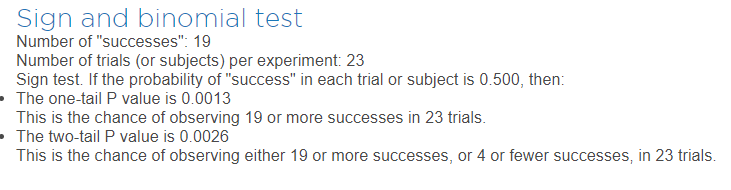

So, P-Value of the test is 0.0026. Since the probability to pass the test daily is 1-0.0026 = 0.9974 which is greater than 95%, this result does not happen by chance (statistically significant) and <font color=green>**it passes the sign test**</font>.

#### Net Conversion comparison: 10 failures , 13 successes
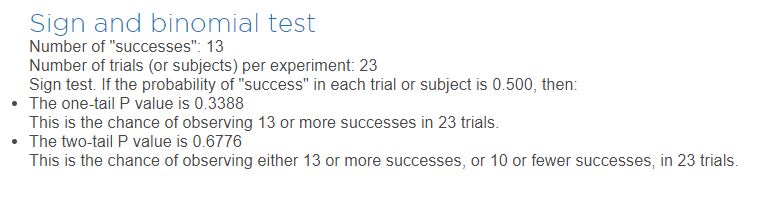

So, P-Value of the test is 0.6776. Since the probability to pass the test daily is 1-0.6776 = 0.3224 which is lower than 95% , <font color=red>**it does NOT pass the sign test.**</font> The experiment will not have statistical significance impact on Net Conversion.